In [ ]:
from PIL import Image as pimg
import requests
from io import BytesIO
from IPython.display import display

# URL of the image
image_url = "https://img.onmanorama.com/content/dam/mm/en/lifestyle/decor/images/2023/6/1/house-middleclass.jpg"

# Fetch the image from the URL using requests
response = requests.get(image_url)
pil_image = pimg.open(BytesIO(response.content))

# Display the image
# display(pil_image)
pil_image.size


(1248, 650)

# Stable Diffusion Initialisation

In [ ]:
!pip -q install transformers diffusers lpips accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Inference

In [ ]:
def image_generator(prompt, neg_prompt, ht, wd, encoded):

    height = ht
    width = wd
    num_inference_steps = 100
    guidance_scale = 7.5
    neg_guidance_scale = 5
    generator = torch.manual_seed(47)
    batch_size = 1

    # Prep text
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    neg_input = tokenizer(neg_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        neg_embeddings = text_encoder(neg_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings, neg_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)
    scheduler._begin_index = 0

    # Prep latents
    if encoded==None:
        latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        )
        latents = latents.to(torch_device)
        latents = latents * scheduler.sigmas[0] # Need to scale to match k

    else:
        noise = torch.randn_like(encoded)
        latents = scheduler.add_noise(encoded, noise, torch.tensor([scheduler.timesteps[0]]))
        latents = latents.to(torch_device)



    # latents = scheduler.scale_model_input(latents, 0)

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            # latents = scheduler.scale_model_input(latents, i)
            latent_model_input = torch.cat([latents] * 3)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text, noise_pred_neg = noise_pred.chunk(3)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond) - neg_guidance_scale * (noise_pred_neg - noise_pred_uncond)
#             noise_pred = noise_pred - guidance_scale * (noise_pred_neg - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]


    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents)

    # Display
    image = (image.sample / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

#     image_bytes = pil_images[0].tobytes()

#     # Encode the byte buffer as a string using Base64
#     encoded_image = base64.b64encode(image_bytes).decode("utf-8")
    return pil_images[0]

In [ ]:
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.mean # or .mean or .sample

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

encoded = None

# URL of the image
image_url = "https://img.freepik.com/free-photo/businessman-holding-tablet_1368-8541.jpg"

# Fetch the image from the URL using requests
response = requests.get(image_url)
pil_image = Image.open(BytesIO(response.content))

img_width, img_height = pil_image.size

h2r = img_height/img_width

a = 512
b = int(h2r * a)

orientation = input("Choose orientation (p/l): ")

if orientation.lower() == 'p':
    new_height = max([a, b])
    new_width = min([a, b])

elif orientation.lower() == 'l':
    new_height = min([a, b])
    new_width = max([a, b])

else:
    print("Please choose between p and l")


resized_pil_frame = pil_image.resize((new_width, new_height))
encoded = pil_to_latent(resized_pil_frame)

Choose orientation (p/l): l


  0%|          | 0/100 [00:00<?, ?it/s]

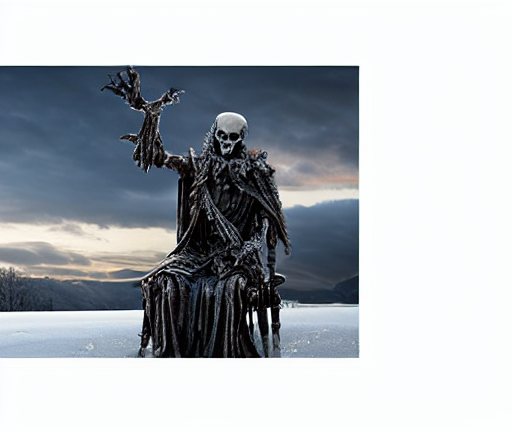

In [ ]:
prompt = "Generate a stunning 4K artwork featuring a Frozen Skeleton King seated upon a desolate throne in a frozen landscape under a dark, stormy sky. The king, an imposing figure with a skeletal body covered in a thin layer of ice and frost, radiates an aura of ancient power and cold menace. His bones glisten in a cold, blueish hue, with icicles hanging from his ribcage and a cracked, icy crown adorning his skull. Clad in a regal, tattered robe that billows in the cold wind, he sits upon a throne of jagged, ice-covered rocks, with snowflakes gently falling around him. The focus of the image should be his glowing, icy blue eyes, captivating the viewer with their eerie intensity amidst the frozen landscape. Ensure intricate details on the king's skeletal features, the tattered robe, and the icy throne, with careful attention to lighting and shadow to enhance the chilling ambiance of the scene."

neg_prompt = "Vibrant, Light exposure, cartoon, drawing, funny"
image_generator(prompt, neg_prompt, new_height, new_width, encoded)

# Image Loop

In [ ]:
# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/electric
!mkdir -p /content/drive/MyDrive/stablediff/electric

# Some settings
#prompt = ["a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight"]
prompt = ["an electric sky city on an alien world"]
height = 512                        # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8.0                # Scale for classifier-free guidance
generator = torch.manual_seed(1200)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

for idx in range(100):
    generator = torch.manual_seed(idx)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.sigmas[0] # Need to scale to match k

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents)

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save(f'/content/drive/MyDrive/stablediff/electric/{idx:04}.jpeg')

# Scheduling and Visualisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.mean # or .mean or .sample

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
# im = Image.open('/kaggle/input/my-video-data/apple.jpg').convert('RGB')
# im = im.resize((512,512))
# encoded = pil_to_latent(im)
# im

import cv2
from PIL import Image

img = cv2.imread('')

new_width = int(3840/2160 * 512)

# Convert frame to RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Convert frame to PIL Image
pil_frame = Image.fromarray(frame_rgb)
resized_pil_frame = pil_frame.resize((512, new_width))
encoded = pil_to_latent(resized_pil_frame)

# Image to Image

In [ ]:
# # Make a folder to store results
# !rm -rf /content/drive/MyDrive/stablediff/noise2
# !mkdir -p /content/drive/MyDrive/stablediff/noise2

# # View a noised version
# noise = torch.randn_like(encoded) # Random noise

# for i in tqdm(range(200)):
#     timestep = i * 5
#     encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
#     img = latents_to_pil(encoded_and_noised)[0]
#     img.save(f'/content/drive/MyDrive/stablediff/noise/{i:04}.jpeg')

# !ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/noise/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
# mp4 = open('out.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=512 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)


In [ ]:
import cv2

prompt = ["A bus moving on a busy street at night and the milky way in the sky, detailed, 4k, artisan"]
# prompt = ["An apple with bite marks, detailed, artisan"]
# height = 910
height = 512
width = new_width
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(4)
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

out_frames = []

for encoded in frames:

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Start step
    start_step = 0
    scheduler._begin_index = start_step
    start_sigma = scheduler.sigmas[start_step]
    start_timestep = scheduler.timesteps[start_step]

    # Prep latents
    noise = torch.randn_like(encoded)
    latents = scheduler.add_noise(encoded, noise, torch.tensor([start_timestep]))
    # latents = encoded + noise * scheduler.sigmas[0]
    latents = latents.to(torch_device)
    # latents = latents * start_sigma  # << NB

    # Loop
    with autocast("cuda"):
        for i, t in enumerate(scheduler.timesteps):
            # if i >= start_step:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

    out_img = latents_to_pil(latents)[0]
    out_frames.append(out_img)
    print(len(out_frames), end="\t")

1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	234	235	236	

In [ ]:
!mkdir -p /kaggle/working/output_folder

In [ ]:
for i, img in enumerate(out_frames):
    img.save(f"/kaggle/working/output_folder/{i:04}.jpg")

import shutil
shutil.make_archive("output_stream", 'zip', "/kaggle/working/output_folder")

# Mixed guidance

In [ ]:
prompts = ['blue fire', 'reticulated python in a tree']
weights = [0.5,0.5]
height = 512
width = 768
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(5)
batch_size = 1

# Prep text
# Embed both prompts
text_embeddings = []
for i in range(len(prompts)):
    text_input = tokenizer([prompts[i]], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings.append(text_encoder(text_input.input_ids.to(torch_device))[0])

# Take the average
weighted_embeddings = torch.zeros(text_embeddings[0].shape).to(torch_device)

with torch.no_grad():
    for i in range(len(prompts)):
        weighted_embeddings.add_(text_embeddings[i] * weights[i])

text_embeddings = weighted_embeddings

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

# Denoising Example

In [ ]:
prompt = 'a futuristic city, abandoned and overgrown with plants, dystopia, bathed in sunlight'
height = 512
width = 768
num_inference_steps = 100
guidance_scale = 8
generator = torch.manual_seed(10)
batch_size = 1

# Make a folder to store results
!rm -rf /content/drive/MyDrive/stablediff/denoising2/
!mkdir -p /content/drive/MyDrive/stablediff/denoising2/

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.

    im_input = latents_to_pil(latents)[0]

    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    im_t0 = latents_to_pil(latents_x0)[0]
    im_noise = latents_to_pil(sigma * noise_pred)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (2304, 512))
    im.paste(im_input, (0, 0))
    im.paste(im_noise, (768, 0))
    im.paste(im_t0, (1536, 0))
    im.save(f'/content/drive/MyDrive/stablediff/denoising2/{i:04}.jpg')

In [ ]:
!ffmpeg -v 1 -y -f image2 -framerate 12 -i /content/drive/MyDrive/stablediff/denoising2/%04d.jpg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1536 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)